In [1]:
import os, sys
sys.path.append('../src')

from copulae1 import *
import plotly.express as px
import plotly.figure_factory as ff

import plotly.graph_objects as go

In [2]:
data = pd.read_csv('../data/btc future and reference rate/coingecko_future.csv')
brr = data.iloc[:,4]
btc = data.iloc[:,5]

u = ECDF(brr)(brr)
v = ECDF(btc)(btc)

In [4]:
import json
with open('../src/configs/config_CRIX_future_Open_v3_MM.json','r') as file:
    config = json.load(file)
config
data_name = config['data_name']
calibration_method  = config['calibration_method']
OHR = pd.read_hdf('../results/'+data_name +'/'+calibration_method+'/best_h.h5')
if not os.path.exists("../results/" + data_name + "/MLE/reports"):
	print("Create new folder for results")
	os.mkdir("../results/" + data_name + "/MLE/reports")
	os.mkdir("../results/" + data_name + "/MM/reports")
    
if calibration_method == "MLE":
    report_path = "../results/" + data_name + "/MLE/reports/"
    result_path = "../results/" + data_name + "/MLE/"
elif calibration_method == "MM":
    report_path = "../results/" + data_name + "/MM/reports/"
    result_path = "../results/" + data_name + "/MM/"

In [5]:
config

{'data_name': 'CRIX_future_Open_v3',
 'spot_name': 'log return CRIX',
 'future_name': 'log return future',
 'calibration_method': 'MM',
 'k_ERM': [10],
 'q_arr': [0.05, 0.1, 0.9, 0.95],
 'q_arr_ES': [0.01, 0.05],
 'q_arr_VaR': [0.01, 0.05],
 'h_Clip': [0, 99999]}

In [7]:
natp_path = '../_mathematica/data_30Days/'
natp_ls = os.listdir(natp_path)
natp_h = [l for l in natp_ls if l.endswith('_h.csv')]
file_names = [l.replace('_h','') for l in natp_h]
OHR_combined = []
for i in range(len(natp_h)):
    _natp_h = pd.DataFrame(open(natp_path+natp_h[i], 'r').readlines())
    _natp_h = _natp_h.iloc[1:7,:]
    file_name = natp_h[i].replace('_h','')
    for i in range(len(_natp_h)):
        _natp_h.iloc[i,0] = np.float32(_natp_h.iloc[i,0].replace('\n',''))
    _natp_h.columns = ['NIG_factor']
    _natp_h.index = ['Variance', 'VaR q=0.01', 'VaR q=0.05', 'ES q=0.01', 'ES q=0.05', 'ERM k=10']
    _natp_h = _natp_h.T
    
    OHR_combined.append(OHR.loc[:,file_name].append(_natp_h))
OHR = pd.concat(OHR_combined, axis=1, keys=file_names).dropna(axis=1)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [6]:
Copula_names = list(OHR.index)

In [7]:
temp = []
for C in Copula_names:
    hs_by_Copula = OHR.loc[C:C,:].melt()
    hs_by_Copula.columns = ['file_name', 'risk_measure', 'OHR']
    hs_by_Copula.loc[:, 'copula'] = C
    temp.append(hs_by_Copula)

OHR_to_math = pd.concat(temp, axis=0)
OHR_to_math.to_csv('../results/coingecko_future_v3/MM/OHR.csv')

In [8]:
Copula_names = list(OHR.index)
risk_measures = OHR.loc[:,'0.csv'].columns
data_path = '../processed_data/'+config['data_name']
ls = list(OHR.melt().variable_0.unique())
# OHR.loc[:,'0.csv'].loc[:,risk_measures[0]]

In [9]:
for i,r in enumerate(risk_measures):
    print(i, r)

0 Variance
1 ERM k=10
2 ES q=0.01
3 ES q=0.05
4 VaR q=0.01
5 VaR q=0.05


In [10]:
# rm = 'ES q=0.05'
rm = risk_measures[0]
rm

'Variance'

In [11]:
rh_arr = []
rs_arr = []
rf_arr = []
for file in ls:
    test = pd.read_csv(data_path +'/test/'+file)
    test.Date = pd.to_datetime(test.Date)
    rs = np.array(test.loc[:, config['spot_name']])
    rf = np.array(test.loc[:, config['future_name']])
    h_arr = OHR.loc[:,file].loc[:,rm]
    rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
    rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
    rh_arr.append(rh)
    
    rs = pd.Series(rs, index=test.Date)
    rf = pd.Series(rf, index=test.Date)
    rs_arr.append(rs)
    rf_arr.append(rf)
    
rh = pd.concat(rh_arr, axis=1)
rh = rh.sort_index(axis=1)
rs = pd.concat(rs_arr)
rs = rs.sort_index()

rf = pd.concat(rf_arr)
rf = rf.sort_index()

rh = rh.apply(pd.to_numeric)

In [12]:
tau_arr = []
date_arr = []
for file in ls:
    train = pd.read_csv(data_path +'/train/'+file)
    test = pd.read_csv(data_path +'/test/'+file)

    test.Date = pd.to_datetime(test.Date)
    date_arr.append(test.Date.iloc[0])
    
    train_tau = stats.kendalltau(train.loc[:,config['spot_name']], train.loc[:,config['future_name']])[0]
    test_tau = stats.kendalltau(test.loc[:,config['spot_name']], test.loc[:,config['future_name']])[0]

    tau_arr.append(train_tau - test_tau)

tau_arr = pd.Series(tau_arr, index=date_arr)
tau_arr = tau_arr.sort_index()
tau_arr.loc[rh.columns[0]] = tau_arr.iloc[0] # add a row for plotting
tau_arr = tau_arr.sort_index()

In [15]:
# plt.figure(figsize=(20,5))
# plt.plot(rs, 'r')
# q = 0.05

# rs_U = rs.loc[rs<=np.quantile(rs,q)]
# plt.plot(np.array(rs_U.index),np.array(rs_U),'rx')

# rs_L = rs.loc[rs>np.quantile(rs,1-q)]
# plt.plot(np.array(rs_L.index),np.array(rs_L),'r+')

# rf_U = rf.loc[rf<=np.quantile(rf,q)]
# plt.plot(np.array(rf_U.index),np.array(rf_U),'bx')

# rf_L = rf.loc[rf>np.quantile(rf,1-q)]
# plt.plot(np.array(rf_L.index),np.array(rf_L),'b+')

# plt.plot(rf, 'b')

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



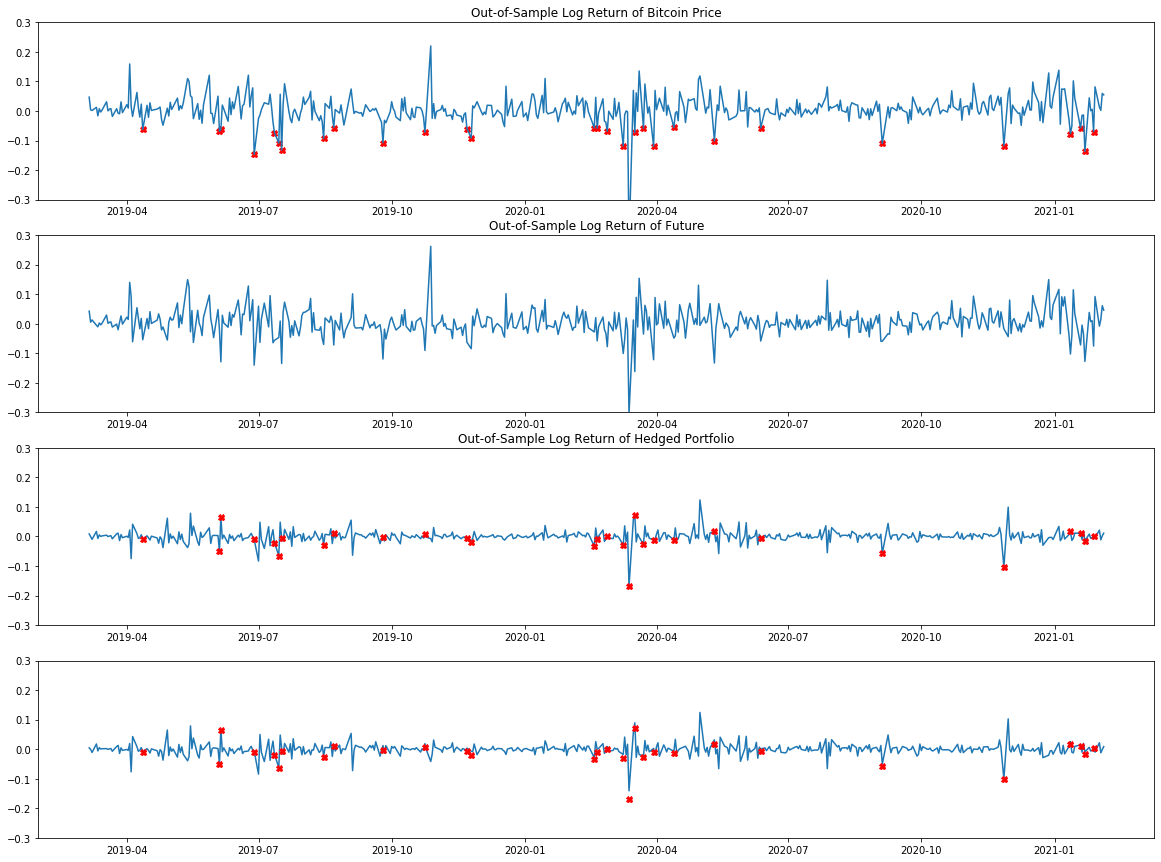

In [13]:
_id_rs = (rs<=np.quantile(rs,30/len(rs))) # 30 smallest rs
_id_rf = (rf<=np.quantile(rs,30/len(rf))) # 30 smallest rs

fig, ax = plt.subplots(figsize=(20,15), nrows=4, ncols=1)
ax[0].plot(rs[_id_rs],'rX')
ax[0].plot(rs)
ax[0].set_ylim((-0.3,0.3))
ax[0].set_title("Out-of-Sample Log Return of Bitcoin Price")

# ax[1].plot(rf[_id_rf],'rX')
ax[1].plot(rf)
ax[1].set_ylim((-0.3,0.3))
ax[1].set_title("Out-of-Sample Log Return of Future")

C = 'Gumbel'
ax[2].plot(rh.loc[C,:])
ax[2].plot(rh.T.loc[_id_rs, C], 'rX')
ax[2].set_ylim((-0.3,0.3))
ax[2].set_title("Out-of-Sample Log Return of Hedged Portfolio")

ax[3].plot(rs - rf)
ax[3].set_ylim((-0.3,0.3))
ax[3].plot(rh.T.loc[_id_rs, C], 'rX')

plt.savefig('../latex/_pics/OOSreturns_compare.pdf')

In [14]:
print(1-ERM_estimate_trapezoidal(10,rh.loc['Gumbel'])/ERM_estimate_trapezoidal(10,rs), 
      1-ERM_estimate_trapezoidal(10,rs-rf)/ERM_estimate_trapezoidal(10,rs))

0.5198190989728398 0.49673487555195495


In [15]:
print(1-VaR(0.01,rh.loc['Gumbel'])/VaR(0.01,rs), 
      1-VaR(0.01,rs-rf)/VaR(0.01,rs))

0.46155616893847495 0.43405558995149784


In [16]:
print(1-VaR(0.05,rh.loc['Gumbel'])/VaR(0.05,rs), 
      1-VaR(0.05,rs-rf)/VaR(0.05,rs))

0.5698079438022946 0.5410645495887587


In [17]:
print(1-ES(0.05,rh.loc['Gumbel'])/ES(0.05,rs), 
      1-ES(0.05,rs-rf)/ES(0.05,rs))

0.5202244549199557 0.511922250309619


In [18]:
print(1-ES(0.01,rh.loc['Gumbel'])/ES(0.01,rs), 
      1-ES(0.01,rs-rf)/ES(0.01,rs))

0.49739217902618704 0.5157368446116546


In [19]:
print(1-Variance(rh.loc['Gumbel'])/Variance(rs), 
      1-Variance(rs-rf)/Variance(rs))

0.7976706036799058 0.7921629109578794


(-0.4, 0.4)

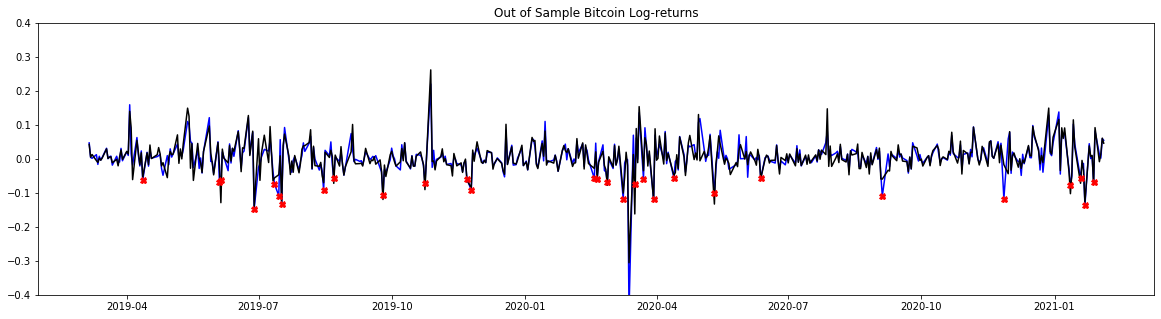

In [20]:
plt.figure(figsize=(20,5))
q=0.1
plt.title('Out of Sample Bitcoin Log-returns')
# print(np.sum(_id))
# _id = (rs<=np.quantile(rs,q)) & (rf<=np.quantile(rf,q)) 
_id = (rs<=np.quantile(rs,30/len(rs))) # 30 smallest rs

plt.plot(rs, 'b')
plt.plot(rf, 'black')
# _id = (rs<=np.quantile(rs,q)) & (rf<=np.quantile(rf,q)) 
plt.plot(rs[_id],'rX')
plt.ylim((-0.4,0.4))

# plt.plot(rf[_id],'bX')
# plt.savefig('../latex/_pics/OOSBitcoin.png', transparent=True)
# _id = (rs>np.quantile(rs,1-q)) & (rf>np.quantile(rf,1-q)) 
# plt.plot(rs[_id],'rX')
# plt.plot(rf[_id],'bX')

In [21]:
# plt.figure(figsize=(20,5))
# plt.plot(rs, 'r')
# q = 0.1

# rs_U = rs.loc[rs<=np.quantile(rs,q)]
# plt.plot(np.array(rs_U.index),np.array(rs_U),'rx')

# rs_L = rs.loc[rs>np.quantile(rs,1-q)]
# plt.plot(np.array(rs_L.index),np.array(rs_L),'r+')

# rf_U = rf.loc[rf<=np.quantile(rf,q)]
# plt.plot(np.array(rf_U.index),np.array(rf_U),'bx')

# rf_L = rf.loc[rf>np.quantile(rf,1-q)]
# plt.plot(np.array(rf_L.index),np.array(rf_L),'b+')

# plt.plot(rf, 'b')

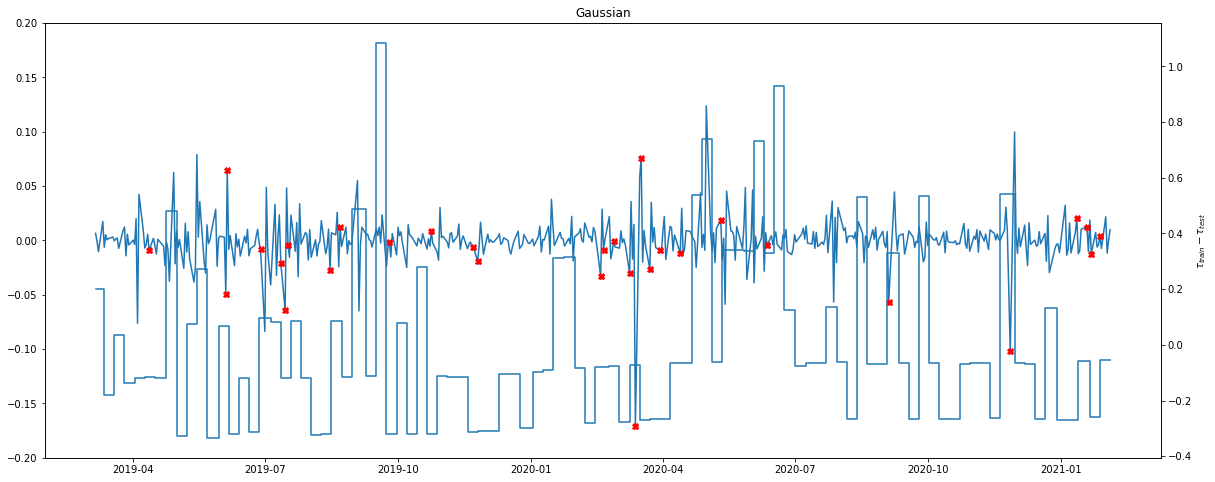

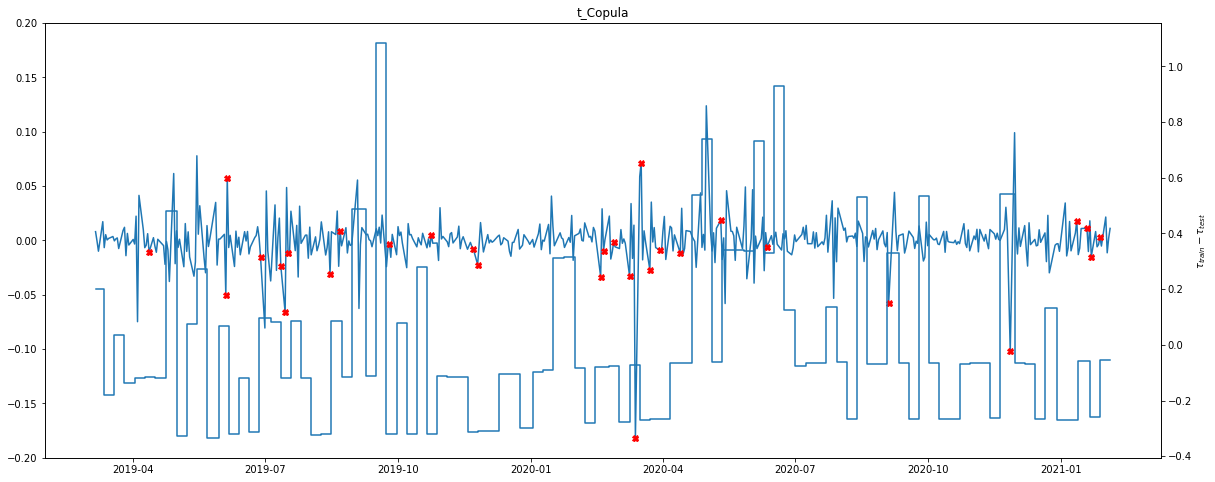

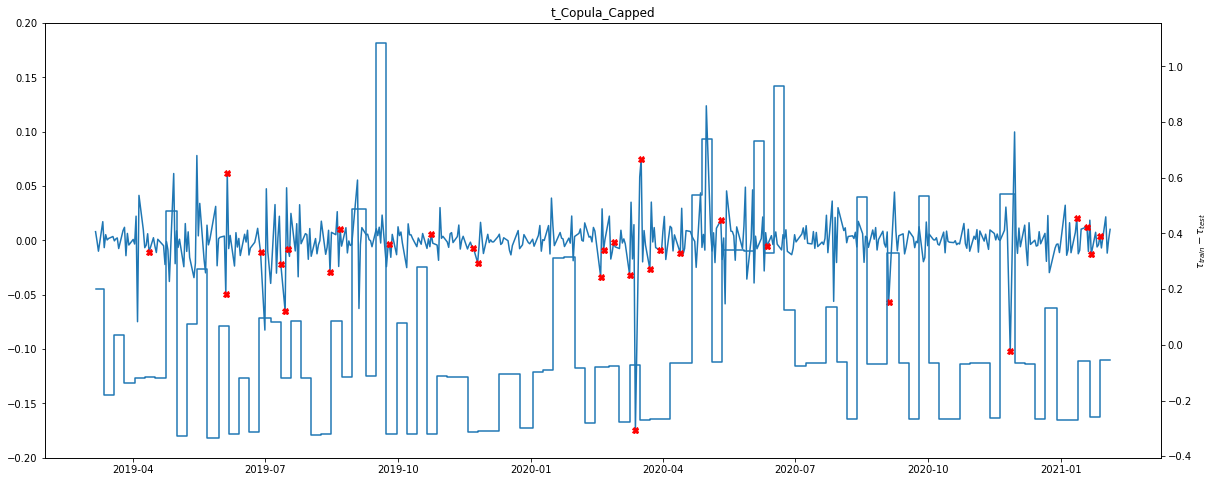

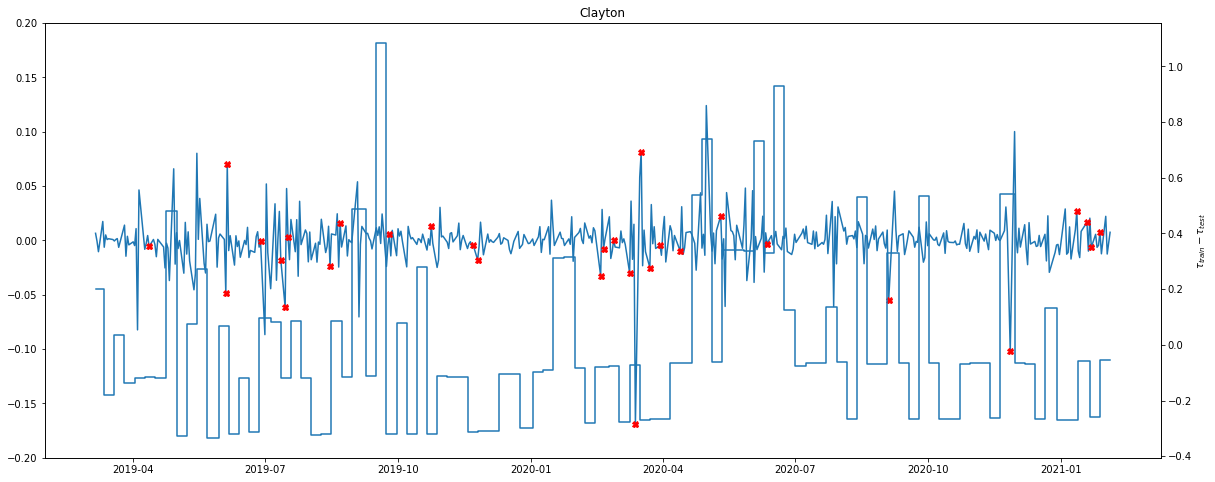

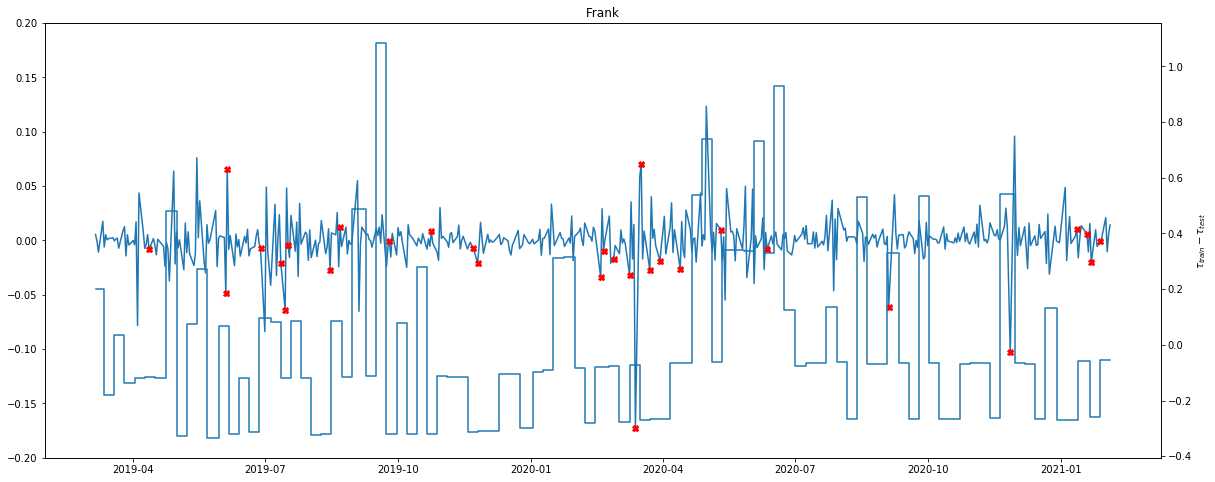

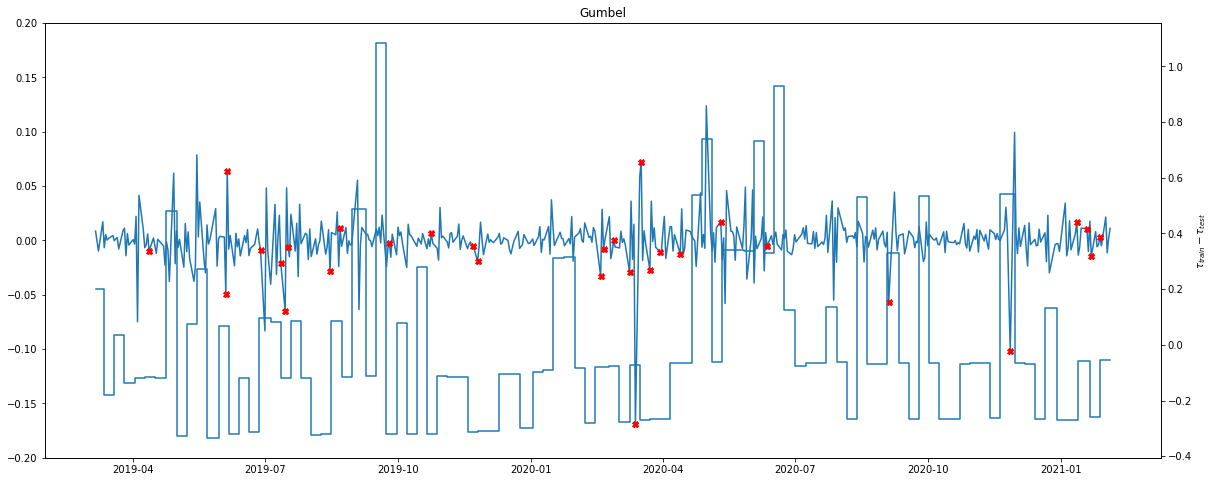

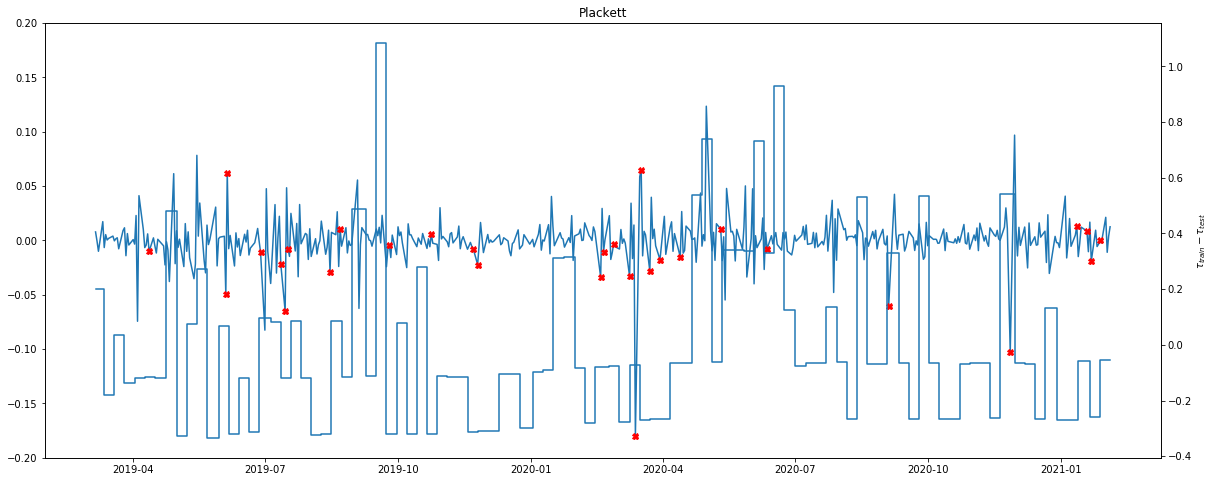

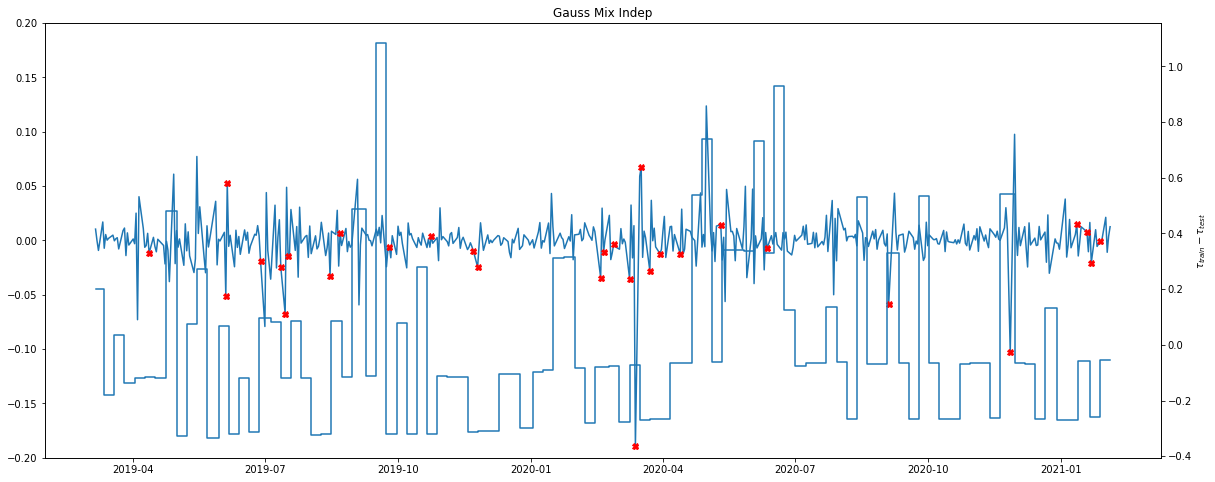

In [22]:
for i in range(len(Copula_names)):
    fig, ax1 = plt.subplots(figsize=(20,1*len(Copula_names)))
    ax2 = ax1.twinx()  
    C = Copula_names[i]
#     plt.figure(figsize=(20,5))
    ax1.set_title(Copula_names[i])
    ax1.plot(rh.loc[C,:])
    ax1.plot(rh.T.loc[_id, C], 'rX')
    ax1.set_ylim((-0.2,0.2))

    ax2.step(tau_arr.index, tau_arr)
    ax2.set_ylabel(r'$\tau_{train} - \tau_{test}$')

#     plt.plot(rh.loc[C,rs_L.index],'rx')
#     plt.plot(rh.loc[C,rs_U.index],'r+')
#     plt.plot(rh.loc[C,rf_L.index],'bx')
#     plt.plot(rh.loc[C,rf_U.index],'b+')
#     plt.ylim((-0.2,0.2))
# plt.hlines(np.quantile(rh.loc[Copula_names[0],:], q), xmin=rh.columns[0], xmax=rh.columns[-1])
# plt.hlines(np.quantile(rh.loc[Copula_names[0],:], 1-q), xmin=rh.columns[0], xmax=rh.columns[-1])

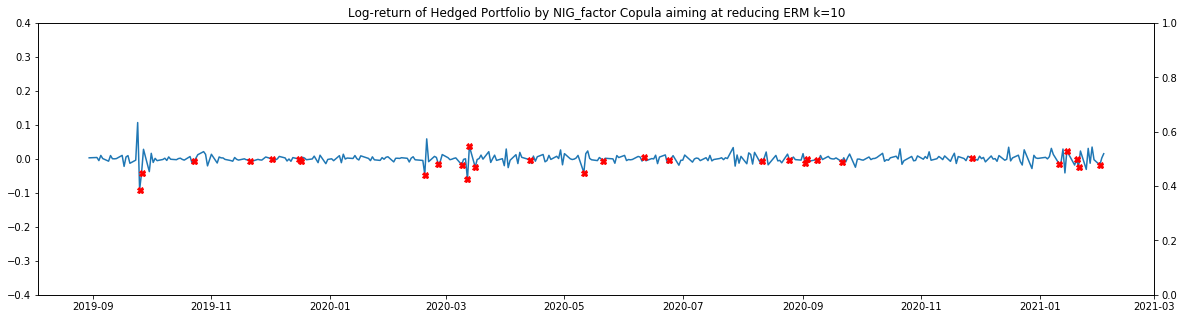

In [25]:
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()  
C = Copula_names[i]
#     plt.figure(figsize=(20,5))
ax1.set_title('Log-return of Hedged Portfolio by '+ Copula_names[i]+' Copula aiming at reducing '+rm)
ax1.plot(rh.loc[C,:])
ax1.plot(rh.T.loc[_id, C], 'rX')
ax1.set_ylim((-0.4,0.4))
plt.savefig('../latex/_pics/Gumbel_rh.png', transparent=True)
# _rh = rh.loc[C,:]
# S = pd.Series({'mean':np.mean(_rh), 
#  'std':np.std(_rh),
#  'skew':stats.skew(_rh),
#  'kurt':stats.kurtosis(_rh),
#  'max': np.max(_rh),
#  'UQ': np.quantile(_rh, 0.75),
#  'median': np.quantile(_rh, 0.5),
#  'LQ': np.quantile(_rh, 0.25), 
#  'min':np.min(_rh)})
# plt.figure(figsize=(5,5))
# sns.distplot(_rh)
# print(S)

In [24]:
print(result_path)

../results/CRIX_future_Open_v3/MM/


In [71]:
rs.index

DatetimeIndex(['2019-03-06 00:00:00+00:00', '2019-03-07 00:00:00+00:00',
               '2019-03-08 00:00:00+00:00', '2019-03-11 00:00:00+00:00',
               '2019-03-12 00:00:00+00:00', '2019-03-13 00:00:00+00:00',
               '2019-03-14 00:00:00+00:00', '2019-03-15 00:00:00+00:00',
               '2019-03-18 00:00:00+00:00', '2019-03-19 00:00:00+00:00',
               ...
               '2021-01-22 00:00:00+00:00', '2021-01-25 00:00:00+00:00',
               '2021-01-26 00:00:00+00:00', '2021-01-27 00:00:00+00:00',
               '2021-01-28 00:00:00+00:00', '2021-01-29 00:00:00+00:00',
               '2021-02-01 00:00:00+00:00', '2021-02-02 00:00:00+00:00',
               '2021-02-03 00:00:00+00:00', '2021-02-04 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=485, freq=None)

ValueError: Tz-aware datetime.datetime cannot be converted to datetime64 unless utc=True

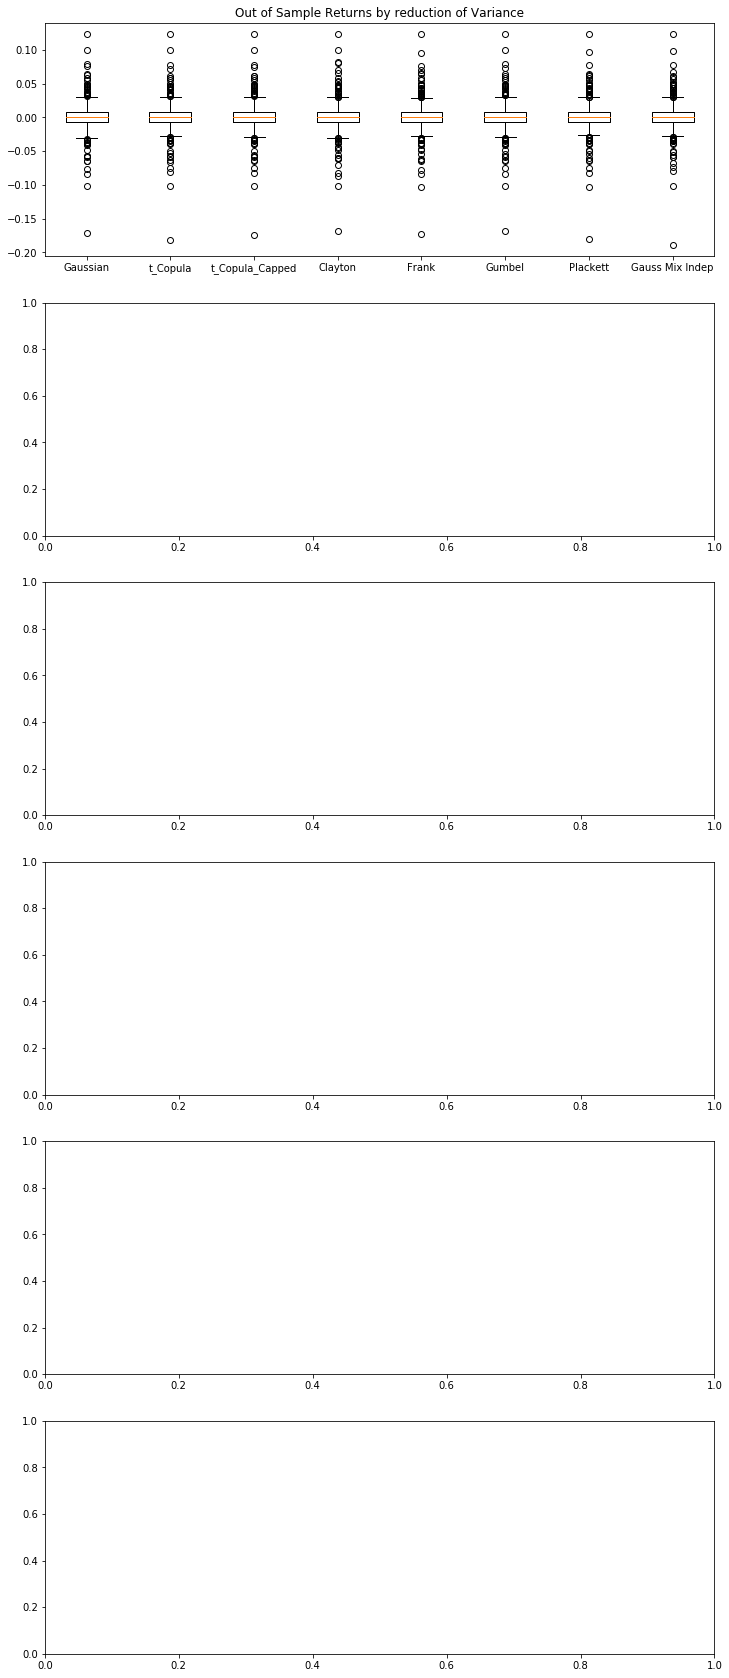

In [23]:
from plotly.subplots import make_subplots
fig, ax = plt.subplots(len(risk_measures), 1, figsize=(12,5*len(risk_measures)))
for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for file in ls:
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)

    rh = pd.concat(rh_arr, axis=1)
    rh = rh.sort_index(axis=1)
    rs = pd.concat(rs_arr)
    rs = rs.sort_index()

    rf = pd.concat(rf_arr)
    rf = rf.sort_index()

    rh = rh.apply(pd.to_numeric)
    ax[i].boxplot(rh)
    ax[i].set_xticklabels(Copula_names)
    ax[i].set_title("Out of Sample Returns by reduction of %s" %rm)
    M = np.mean(rh, axis=1)
    STD = np.std(rh, axis=1)

    MAX = np.max(rh, axis=1)
    MAX_date = rh.isin(MAX).idxmax(axis=1)

    UQ = rh.apply(lambda x: np.quantile(x, 0.75, interpolation='higher'), axis=1)
    UQ_date = rh.isin(UQ).idxmax(axis=1)

    LQ = rh.apply(lambda x: np.quantile(x, 0.25, interpolation='higher'), axis=1)
    LQ_date = rh.isin(LQ).idxmax(axis=1)

    MIN = np.min(rh, axis=1)
    MIN_date = rh.isin(MIN).idxmax(axis=1)

    rh_stats = pd.concat([M, STD, MAX, MAX_date, UQ, UQ_date, LQ, LQ_date, MIN, MIN_date], axis=1)
    rh_stats.columns = ['mean', 'std', 
                        'max', 'max on',
                        'UQ', 'UQ on', 
                        'LQ', 'LQ on',
                        'min', 'min on']
    rh_stats.to_html(result_path+'rh_stats_%s.html'%rm)



    for C in Copula_names:
        _rh = rh.loc[C,:]

        fig = make_subplots(
            rows=3, cols=2,
            column_widths=[10, 10],
            row_heights=[10, 10, 10],
            specs=[[{"type":"xy","colspan": 2}, None],
                   [{"type":"xy","colspan": 2}, None],
                   [{"type": "histogram2d"}, {"type":"table"}]],
            subplot_titles=("Rh Time Series","OHR", "Histogram", "Rh Statistics"))
        
        # Line plot with extreme data points
        df = pd.DataFrame(_rh).reset_index()
        fig.add_trace(go.Scatter(x=df.loc[:,'Date'], y=df.loc[:,C]), row=1,col=1)
        fig.add_trace(go.Scatter(x=rh.T.loc[_id, C].index, y=rh.T.loc[_id, C],
                            mode='markers'))
        fig.update_yaxes(range=[-0.2, 0.2], row=1, col=1)

        
        # Step plot of h
        dates = [pd.read_csv(data_path +'/test/'+file).iloc[-1,:].Date for file in ls]
        end_date = _rh.index[-1]
        h_4plot = pd.concat([OHR.loc[:, file].loc[:,rm] for file in ls],keys = dates, axis=1)
        h_4plot = h_4plot.sort_index(axis=1)
        h_4plot.loc[:,end_date] = h_4plot.iloc[:,-1]
        fig.add_trace(go.Scatter(x=pd.to_datetime(h_4plot.columns), y=h_4plot.loc[C,:], line= {"shape": 'hv'}),
                      row=2,col=1)
        fig.update_yaxes(range=[np.min(np.min(OHR))*.9, np.max(np.max(OHR))*1.1], row=2, col=1)

        # Table
        S = pd.Series({'mean':np.mean(_rh), 
         'std':np.std(_rh),
         'skew':stats.skew(_rh),
         'kurt':stats.kurtosis(_rh),
         'max': np.max(_rh),
         'UQ': np.quantile(_rh, 0.75),
         'median': np.quantile(_rh, 0.5),
         'LQ': np.quantile(_rh, 0.25), 
         'min':np.min(_rh)})
        df = pd.DataFrame(S)
        df = df.reset_index()
        df.columns = ['Statistics', 'Value']
        fig.add_trace(go.Table(
            header=dict(values=list(df.columns),
                        fill_color='paleturquoise',
                        align='left'),
            cells=dict(values=[df.iloc[:,0],df.iloc[:,1]],
                       fill_color='lavender',
                       align='left'))
        , row=3,col=2)

        uq = np.quantile(_rh, .75)
        lq = np.quantile(_rh, .25)
        bw = 1.06*min(np.std(_rh), (uq-lq)/1.34)*len(_rh)**(-1/5)

        distplfig = ff.create_distplot([np.array(_rh)],
                                       ['rh'], bin_size=bw, show_rug=False)

        fig.add_trace(go.Histogram(distplfig['data'][0],
                                   marker_color='red'
                                  ), row=3, col=1)

        fig.update_layout(height=1000, width=1200, title_text=C+' '+rm)

        fig.write_html(report_path+C+"_"+rm+".html")
        
plt.savefig(result_path+'Out of Sample Returns Boxplot.pdf', transparent=True)


In [29]:
h_diff_arr = []
for rm in risk_measures:
    h = OHR.droplevel(0,1).loc[:, rm]
    h_diff = np.sum(np.abs(h.iloc[:,:-1] - h.iloc[:,1:]), axis=1)
    h_diff_arr.append(h_diff)

In [30]:
h_diff_df = pd.concat(h_diff_arr, axis=1)
h_diff_df.columns = risk_measures

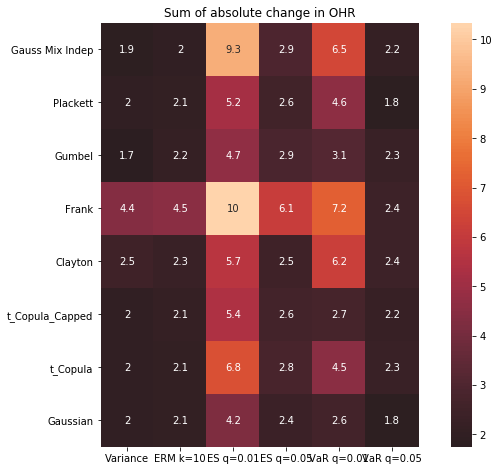

In [31]:
plt.figure(figsize=(9*1.3,6*1.3))
# sns.cubehelix_palette(as_cmap=True, reverse=True)
sns.heatmap(h_diff_df,square=True, center=True, annot=True)
plt.ylim(0,len(h_diff_df))
plt.title('Sum of absolute change in OHR')
plt.savefig(result_path+'Sum of absolute change in OHR.pdf', transparent=True)

In [38]:
h_diff_df

,Variance,ERM k=10,ES q=0.01,ES q=0.05,VaR q=0.01,VaR q=0.05
Gaussian,1.987109,2.077441,4.236621,2.383301,2.648535,1.845508
t_Copula,2.005371,2.109766,6.837402,2.803613,4.544238,2.314355
t_Copula_Capped,2.038184,2.120703,5.438379,2.638086,2.741602,2.190527
Clayton,2.536523,2.268359,5.705273,2.487207,6.213672,2.429395
Frank,4.386035,4.526367,10.337012,6.116895,7.248633,2.434473
Gumbel,1.748047,2.183008,4.728613,2.882617,3.146094,2.261719
Plackett,2.013281,2.083203,5.181641,2.615723,4.623926,1.831738
Gauss Mix Indep,1.855762,2.032227,9.284668,2.927930,6.483203,2.160547


In [41]:
# h_diff_df.iloc[[0,1,2,3,5,6,7],:].style.highlight_min(color = 'lightgreen', axis = 0)
h_diff_df.style.highlight_min(color = 'lightgreen', axis = 0)

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

In [51]:
def hedging_effectiveness2(rm, rh, rs):
	if rm.startswith('Variance'):
		return 1 - Variance(rh) / Variance(rs)

	elif rm.startswith('ERM'):
		k = float(rm[rm.find('=') + 1:])
		return 1 - ERM_estimate_trapezoidal(k, rh) / ERM_estimate_trapezoidal(k, rs)

	elif rm.startswith('ES'):
		q = float(rm[rm.find('=') + 1:])
		return 1 - ES(q, rh) / ES(q, rs)

	elif rm.startswith('VaR'):
		q = float(rm[rm.find('=') + 1:])
		return 1 - VaR(q, rh) / VaR(q, rs)

In [52]:
for C in Copula_names:
    print(hedging_effectiveness2(rm=rm, rh=rh.loc[C,:], rs=rs))

46.12871099357414
46.86272014126965
46.2375197553448
47.24337284852981
46.65814229739046
45.76113926231832
46.775373105265125
47.41024213944469


In [54]:
HE2 = []
rm = 'ES q=0.01'
C='Gaussian'

for _ in range(1000):
    _id = np.random.choice(range(len(rh.loc[C,:])),len(rh.loc[C,:]), True)
    HE2.append(hedging_effectiveness2(rm=rm,
                                      rh=rh.loc[C,:].iloc[_id],
                                      rs=rs.iloc[_id]))
    


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [55]:
OHR.iloc[[0,1,3,4,5,6,7]]

0.csv                                                      \
                 Variance  ERM k=10 ES q=0.01 ES q=0.05 VaR q=0.01 VaR q=0.05   
Gaussian         0.971094  0.922852  1.202832  0.958789   0.937207   0.865332   
t_Copula         0.946582  0.911816  1.228223  0.940820   0.843652   0.877441   
Clayton          1.024121  0.923535  1.195703  0.887109   0.803516   0.958008   
Frank            0.878516  0.878809  0.994629  0.877246   0.887891   0.865527   
Gumbel           0.944824  0.980664  1.247852  1.035449   1.108984   0.943750   
Plackett         0.914648  0.904883  1.132129  0.912305   0.883887   0.878711   
Gauss Mix Indep  0.913477  0.913086  1.156055  0.933691   0.612305   0.928516   

                    1.csv                                ...    95.csv  \
                 Variance  ERM k=10 ES q=0.01 ES q=0.05  ... ES q=0.01   
Gaussian         0.977051  0.918457  1.207520  0.948340  ...  1.364844   
t_Copula         0.955176  0.910156  1.231152  0.934277  ...  1.303809   
Clayton          1.021777  0.916895  1.197949  0.887988  ...  1.089746   
Frank            0.913574  0.921094  1.150488  0.936816  ...  1.407520   
Gumbel           0.956543  0.979687  1.243848  1.030762  ...  1.659082   
Plackett         0.922363  0.904590  1.123828  0.909277  ...  1.313965   
Gauss Mix Indep  0.910352  0.913574  1.144141  0.915430  ...  1.039453   

                                                   96.csv                      \
                ES q=0.05 VaR q=0.01 VaR q=0.05  Variance  ERM k=10 ES q=0.01   
Gaussian         1.201367   1.225195   1.021973  0.951562  1.106348  1.327148   
t_Copula         1.179004   1.177539   1.024805  0.917187  1.064746  1.160156   
Clayton          0.911328   0.913477   0.895508  0.952441  0.899316  0.897656   
Frank            1.161523   1.183398   1.017383  0.979004  1.111426  1.370508   
Gumbel           1.367188   1.472852   1.198438  0.904395  1.200977  1.604785   
Plackett         1.112305   1.107422   1.021777  0.923047  1.063086  1.249512   
Gauss Mix Indep  1.123047   1.037793   1.089453  0.862012  1.023047  0.919434   

                                                 
                ES q=0.05 VaR q=0.01 VaR q=0.05  
Gaussian         1.180957   1.212500   1.028223  
t_Copula         1.118262   1.131445   1.029688  
Clayton          0.868262   0.842383   0.898340  
Frank            1.163281   1.216016   1.031250  
Gumbel           1.346777   1.460938   1.168750  
Plackett         1.099512   1.143555   1.018848  
Gauss Mix Indep  1.001660   0.975977   1.103906  

[7 rows x 582 columns]

In [56]:
def rename_rm(rm):
    rm = rm.replace('q=','')
    rm = rm.replace('0.01', '99%')
    rm = rm.replace('0.05', '95%')
    return rm

rename_rm('ES q=0.01')

'ES 99%'

In [57]:
OHR2 = OHR.iloc[[0,2,3,4,5,6,7]] # remove t copula, leaving only the capped version

ls = OHR.melt().variable_0.unique()
Copula_names = list(OHR2.index)
HE2 = np.ones((len(risk_measures),len(ls), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for j, file in enumerate(ls):
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR2.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)
        
        for k, C in enumerate(Copula_names):
            HE2[i, j, k]= hedging_effectiveness2(rm=rm, rh=rh.loc[C,:], rs=rs)

In [58]:
OHR_results = []
for i, C in enumerate(Copula_names):
    df = OHR2.iloc[i:i+1,:].melt()
    df.columns = ['file', 'risk_measure', 'OHR']
    df.loc[:,'copula'] = C
    
    OHR_results.append(df)
    
OHR_results = pd.concat(OHR_results)

In [59]:
OHR_results

,file,risk_measure,OHR,copula
0,0.csv,Variance,0.971094,Gaussian
1,0.csv,ERM k=10,0.922852,Gaussian
2,0.csv,ES q=0.01,1.202832,Gaussian
3,0.csv,ES q=0.05,0.958789,Gaussian
4,0.csv,VaR q=0.01,0.937207,Gaussian
5,0.csv,VaR q=0.05,0.865332,Gaussian
6,1.csv,Variance,0.977051,Gaussian
7,1.csv,ERM k=10,0.918457,Gaussian
8,1.csv,ES q=0.01,1.207520,Gaussian
9,1.csv,ES q=0.05,0.948340,Gaussian


In [226]:
for i, rm in enumerate(risk_measures):
    plt.figure(figsize=(10,5))
    plt.title("Hedging Effectiveness "+ rename_rm(rm))
    plt.boxplot(HE2[i,:,:])
    plt.xticks(range(1, len(Copula_names)+1), Copula_names)
    path = '../latex/_pics/hedging_effectiveness_30days/'
    plt.savefig(path+'%s_30days.pdf'%rename_rm(rm).replace(' ', '_'))
    plt.close()


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histogram

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histogram

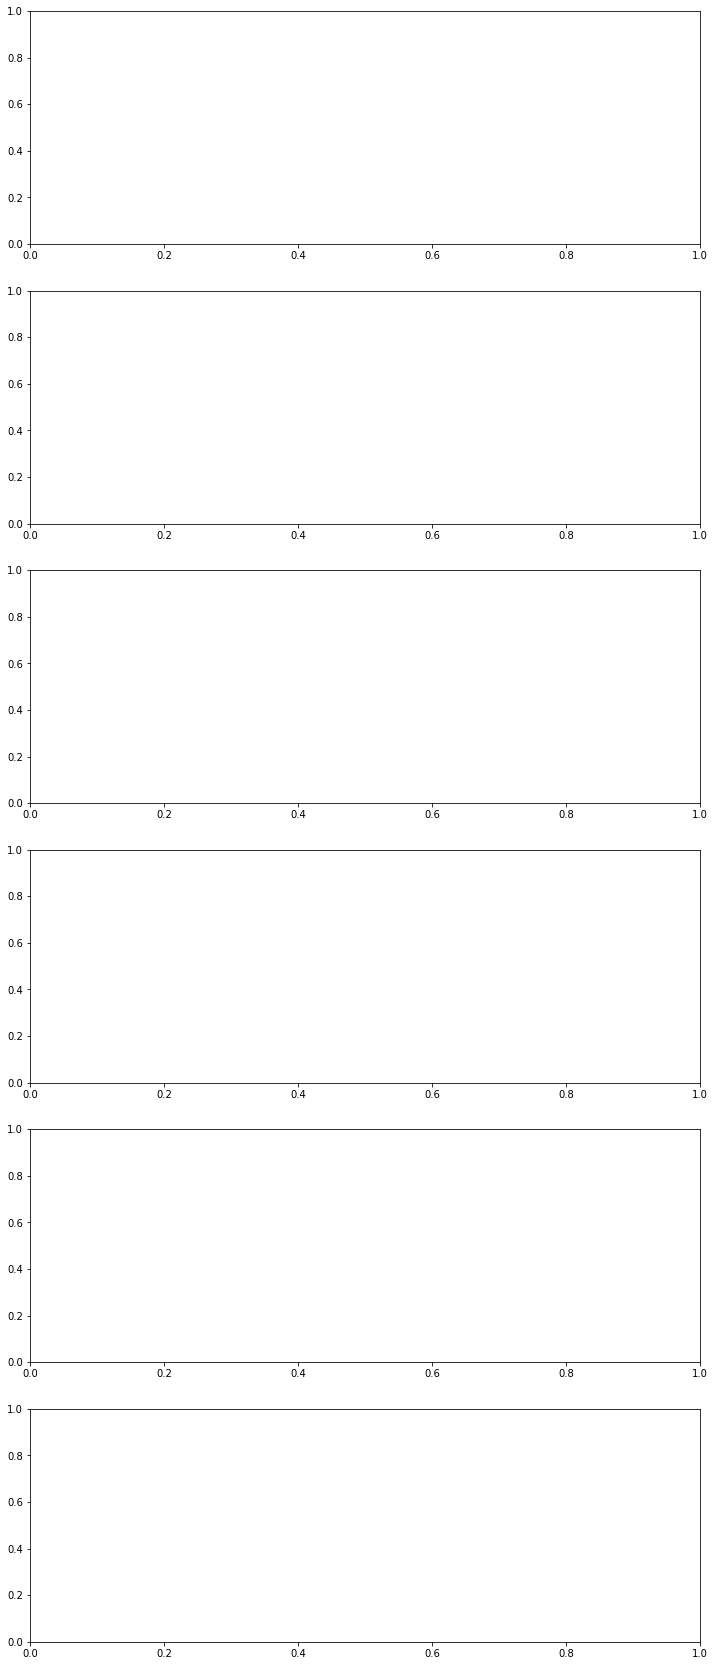

In [60]:
# _id = (rs<=np.quantile(rs,30/len(rs))) # 30 smallest rs
fig, ax = plt.subplots(len(risk_measures), 1, figsize=(12,5*len(risk_measures)))

for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for file in ls:
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR2.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)

    rh = pd.concat(rh_arr, axis=1)
    rh = rh.sort_index(axis=1)
    rs = pd.concat(rs_arr)
    rs = rs.sort_index()

    rf = pd.concat(rf_arr)
    rf = rf.sort_index()

    rh = rh.apply(pd.to_numeric)
    for C in Copula_names:
        plt.figure(figsize=(10,5))
        sns.distplot(rh.iloc[6,:])
        plt.xlabel('Log Return')
        plt.xlim((-0.15,0.15))
        plt.title('Out-of-Sample Hedged Portfolio Returns Using ' + C + ' minimizing '+ rename_rm(rm))
        path = '../latex/_pics/OOS_returns_30days/'
        plt.savefig(path+'OOS_returns_%s_%s_30days.pdf'%(C, rename_rm(rm).replace(' ', '_')))
        plt.close()#     plt.plot()

In [61]:
for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for file in ls:
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR2.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)

    rh = pd.concat(rh_arr, axis=1)
    rh = rh.sort_index(axis=1)
    rs = pd.concat(rs_arr)
    rs = rs.sort_index()

    rf = pd.concat(rf_arr)
    rf = rf.sort_index()

    rh = rh.apply(pd.to_numeric)

In [62]:
rh.iloc[i:i+1, :].melt()

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/melt.py:106: FutureWarning:

Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.



,Date,value
0,2019-03-06,0.003671
1,2019-03-07,-0.001082
2,2019-03-08,-0.011273
3,2019-03-11,0.017712
4,2019-03-12,-0.005625
5,2019-03-13,0.005037
6,2019-03-14,0.000672
7,2019-03-15,0.001536
8,2019-03-18,0.001253
9,2019-03-19,-0.000554


In [63]:
rs

Date
2019-03-06 00:00:00+00:00    0.047091
2019-03-07 00:00:00+00:00    0.004218
2019-03-08 00:00:00+00:00    0.001856
2019-03-11 00:00:00+00:00    0.012480
2019-03-12 00:00:00+00:00   -0.016170
2019-03-13 00:00:00+00:00    0.007691
2019-03-14 00:00:00+00:00   -0.003312
2019-03-15 00:00:00+00:00    0.004193
2019-03-18 00:00:00+00:00    0.031326
2019-03-19 00:00:00+00:00    0.000734
2019-03-20 00:00:00+00:00    0.006162
2019-03-21 00:00:00+00:00    0.008245
2019-03-22 00:00:00+00:00   -0.018360
2019-03-25 00:00:00+00:00    0.007819
2019-03-26 00:00:00+00:00   -0.007611
2019-03-27 00:00:00+00:00   -0.009326
2019-03-28 00:00:00+00:00    0.030994
2019-03-29 00:00:00+00:00   -0.005425
2019-04-01 00:00:00+00:00    0.021451
2019-04-02 00:00:00+00:00    0.010141
2019-04-03 00:00:00+00:00    0.159347
2019-04-04 00:00:00+00:00    0.015079
2019-04-05 00:00:00+00:00   -0.018295
2019-04-08 00:00:00+00:00    0.062846
2019-04-09 00:00:00+00:00    0.010970
2019-04-10 00:00:00+00:00   -0.020816
2019-04

In [64]:
plt.figure(figsize=(10,5))
sns.distplot(rf)
plt.xlabel('Log Return')
plt.xlim((-0.30,0.15))
plt.title('Out-of-Sample Bitcoin Future')

plt.savefig('OOS_BTC_future.pdf')
plt.close()#     plt.plot()

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



In [161]:
plt.figure(figsize=(10,5))
sns.distplot(rs)
plt.xlabel('Log Return')
plt.xlim((-0.30,0.15))
plt.title('Out-of-Sample BTC returns')

plt.savefig('OOS_BTC_return.pdf')
plt.close()#     plt.plot()

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



In [224]:
for C in Copula_names:
    for rm in risk_measures:
        _temp = []
        for file in ls:
            testing_file = pd.read_csv('../processed_data/'+data_name+'/test/'+file)
            testing_file.Date = pd.to_datetime(testing_file.Date)
            testing_file.loc[:,"h"] = OHR2.loc[C, file][rm]
            _temp.append(testing_file)
            
        h_to_plot = pd.concat(_temp)
        h_to_plot.sort_values("Date", inplace=True)
        
        plt.figure(figsize=(10,5))
        plt.title('Calibrated OHR by %s minimizing %s' %(C, rename_rm(rm)))
        plt.ylim((0.4,1.2))
        plt.plot(h_to_plot.Date, h_to_plot.h)
        path = '../latex/_pics/OHR_30days/'
        plt.savefig(path+'OHR_%s_%s_30days.pdf'%(C, rename_rm(rm).replace(' ', '_')))
        plt.close() 

In [212]:
h_to_plot = pd.concat(_temp)
h_to_plot.sort_values("Date", inplace=True)
plt.plot(h_to_plot.Date, h_to_plot.h)

In [222]:
plt.figure(figsize=(10,5))
plt.title('Calibrated OHR by %s minimizing %s' %(C, rename_rm(rm)))
plt.ylim((0.6,1.2))
plt.plot(h_to_plot.Date, h_to_plot.h)
path = '../latex/_pics/OHR_30days/'
plt.savefig(path+'OHR_%s_%s_30days.pdf'%(C, rename_rm(rm).replace(' ', '_')))
plt.close()#     plt.plot()

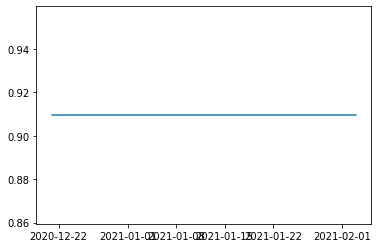

In [204]:
plt.plot(testing_file.Date, testing_file.h)

NameError: name 'rh_df' is not defined

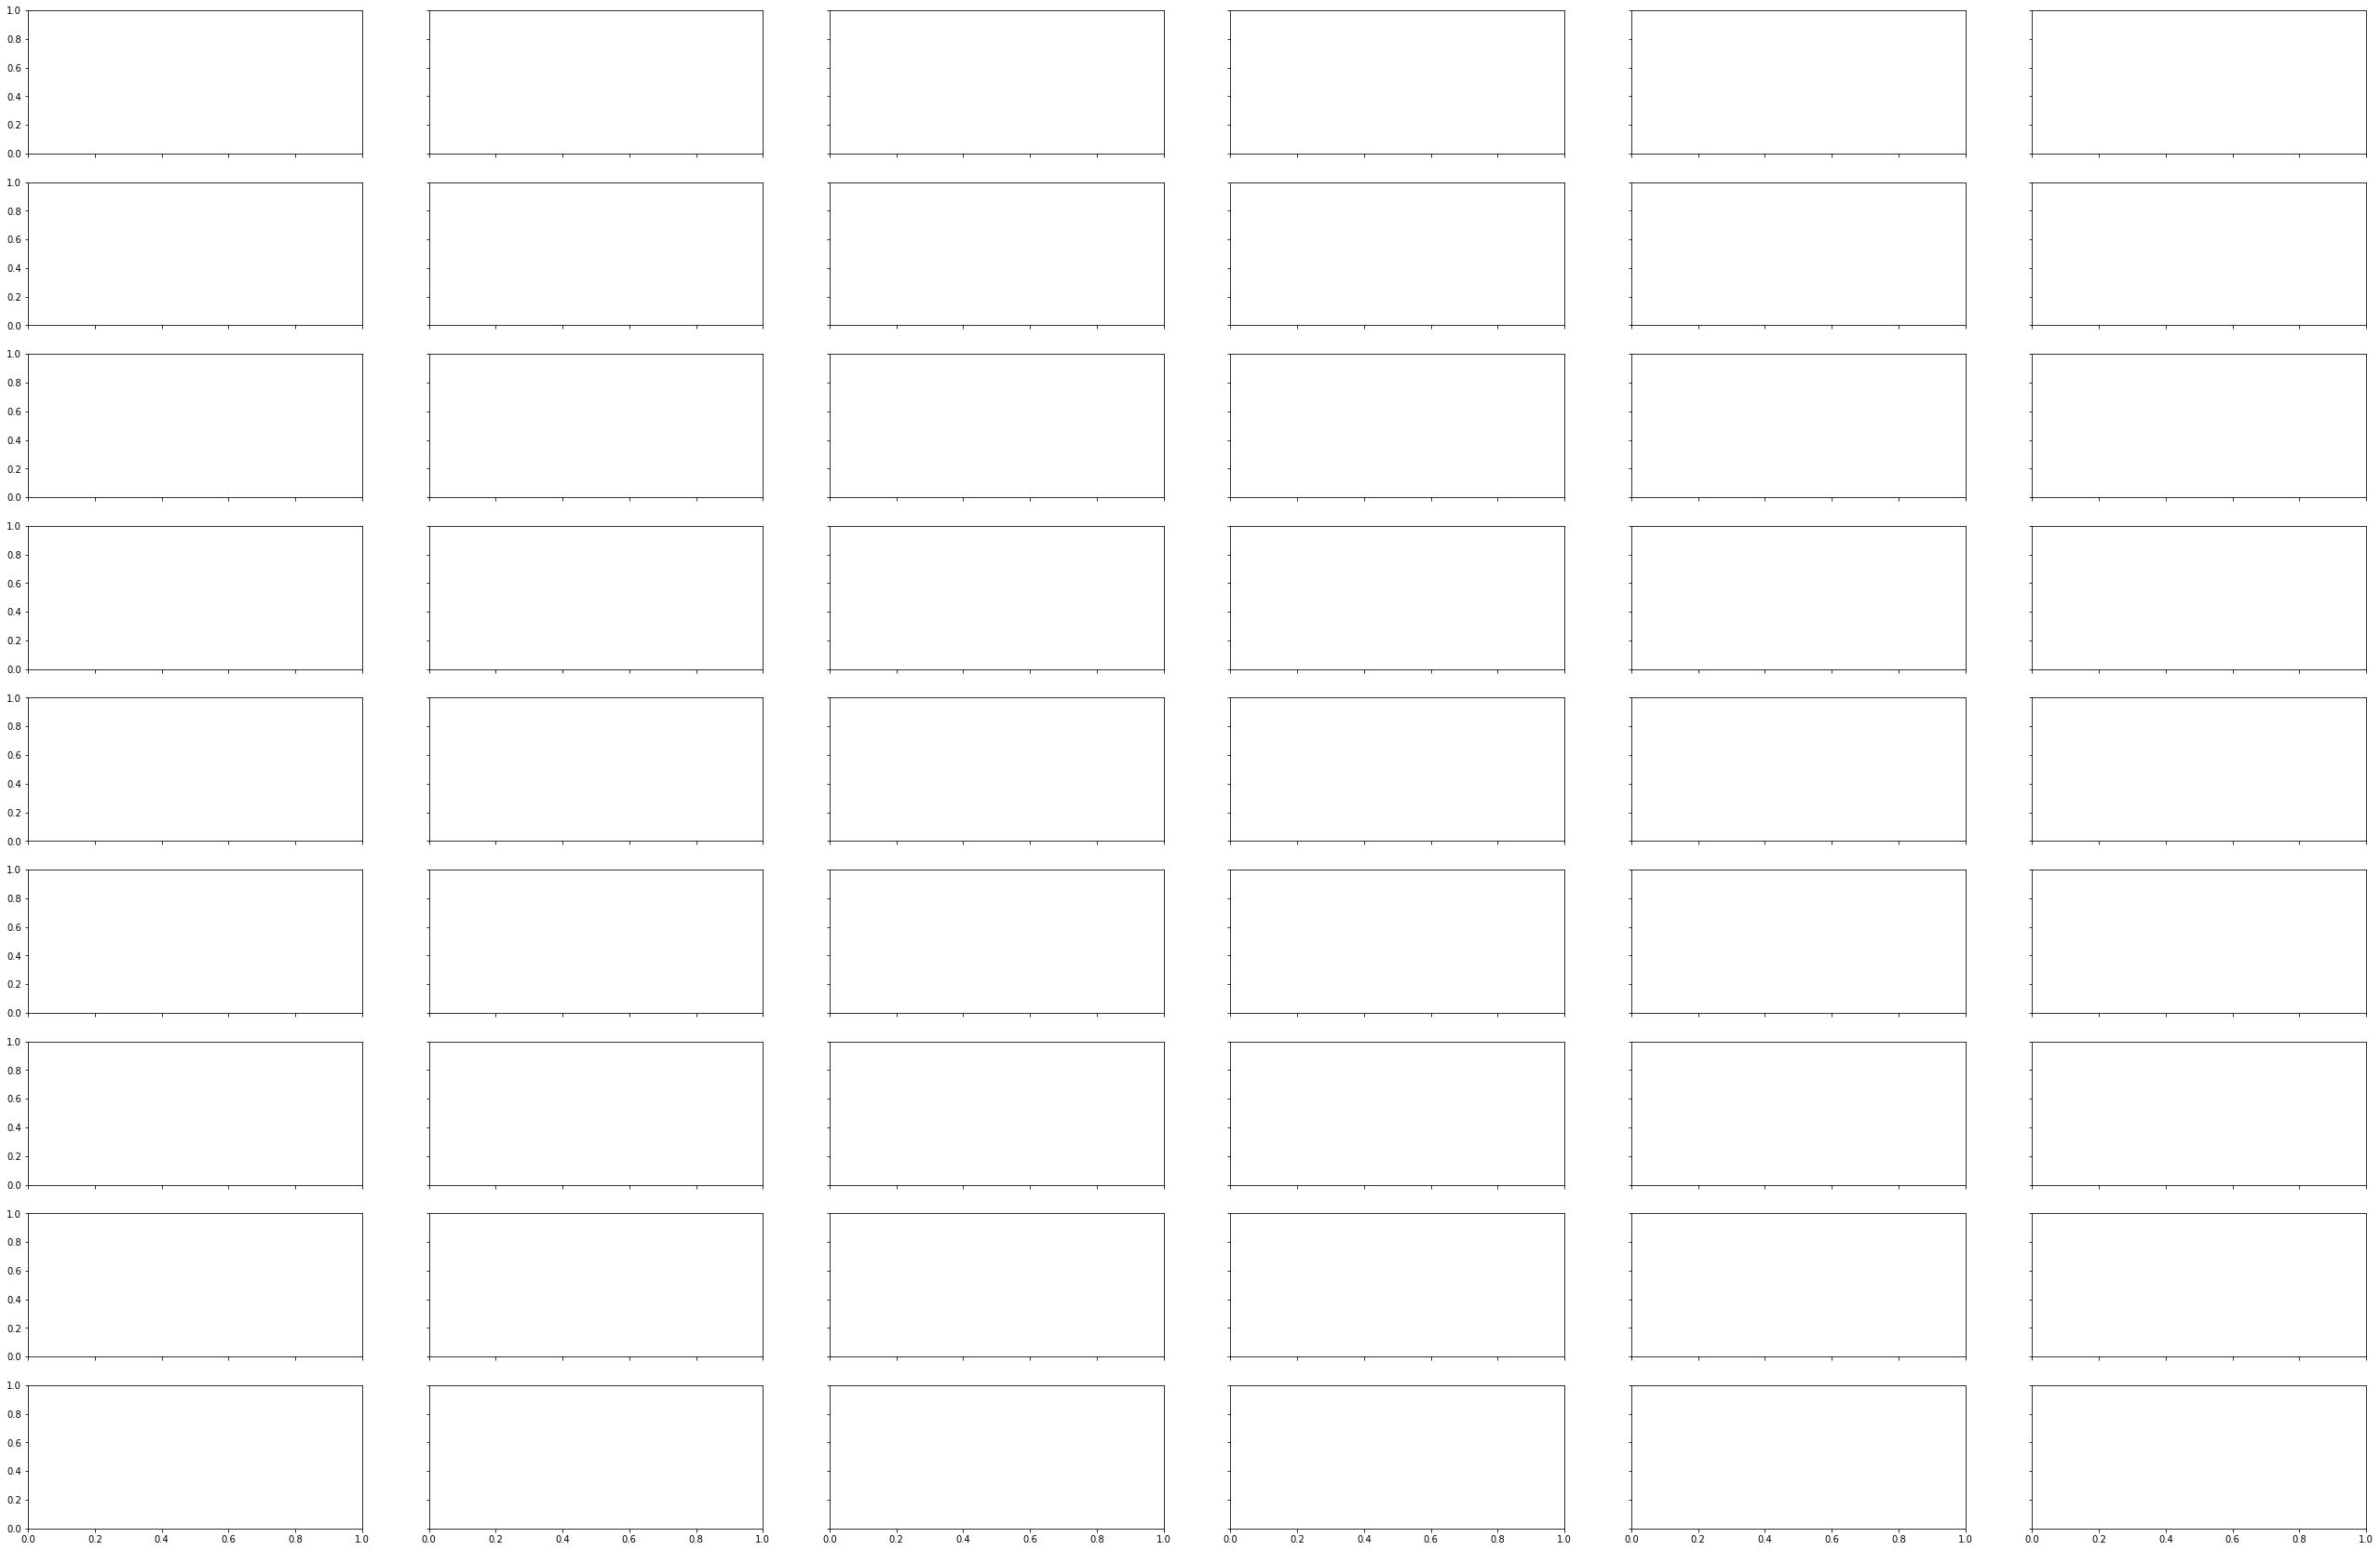

In [46]:
# N=2
fig, ax = plt.subplots(len(Copula_names),
                       len(risk_measures), 
                       figsize=(5*len(Copula_names),5*len(risk_measures)),
                       sharey=True,  sharex=True)

for i in range(len(Copula_names)):
    for j in range(len(risk_measures)):
        ax[i, j].plot(rh_df[j].T.loc[:,Copula_names[i]])
        ax[i,j].set_ylim((-0.15,0.15))
        if j==0:
            ax[i,j].set_ylabel(Copula_names[i])
        if i==0:
            ax[i,j].set_title(rename_rm(risk_measures[j]))
        ax[i,j].scatter(x= _id[_id].index, y=rh_df[j].T.loc[_id,Copula_names[i]], color='r')
plt.tight_layout(pad=0.01)
plt.savefig('../latex/_pics/Rhs.pdf', transparent=True)

In [ ]:

HE_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        HE_np[i,j]=hedging_effectiveness2(rm, rh_df[i].loc[C,:], rs)

In [ ]:
HE_overall = pd.DataFrame(HE_np).T
HE_overall.columns = [rename_rm(rm) for rm in risk_measures]
HE_overall.index = Copula_names
HE_overall.style.highlight_max(color = 'lightgreen', axis = 0)

In [ ]:
Variance_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        Variance_np[i,j]=Variance(rh_df[i].loc[C,:])**0.5
        
Variance_overall = pd.DataFrame(Variance_np).T
Variance_overall.columns = [rename_rm(rm) for rm in risk_measures]
Variance_overall.index = Copula_names
Variance_overall.style.highlight_min(color = 'lightgreen', axis = 1)

In [ ]:
Variance_overall.style.highlight_min(color = 'lightgreen', axis = 0)

In [ ]:
ERM_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        ERM_np[i,j]=ERM_estimate_trapezoidal(10, rh_df[i].loc[C,:])
        
ERM_overall = pd.DataFrame(ERM_np).T
ERM_overall.columns = [rename_rm(rm) for rm in risk_measures]
ERM_overall.index = Copula_names
ERM_overall.style.highlight_min(color = 'lightgreen', axis = 1)

In [ ]:
ERM_overall.style.highlight_min(color = 'lightgreen', axis = 0)

In [ ]:
VaR_99_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        VaR_99_np[i,j]=VaR(.01, rh_df[i].loc[C,:])
        
VaR_99_overall = pd.DataFrame(VaR_99_np).T
VaR_99_overall.columns = [rename_rm(rm) for rm in risk_measures]
VaR_99_overall.index = Copula_names
VaR_99_overall.style.highlight_min(color = 'lightgreen', axis = 1)

In [ ]:
VaR_99_overall.style.highlight_min(color = 'lightgreen', axis = 0)

In [ ]:
VaR_95_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        VaR_95_np[i,j]=VaR(.05, rh_df[i].loc[C,:])
        
VaR_95_overall = pd.DataFrame(VaR_95_np).T
VaR_95_overall.columns = [rename_rm(rm) for rm in risk_measures]
VaR_95_overall.index = Copula_names
VaR_95_overall.style.highlight_min(color = 'lightgreen', axis = 1)

In [ ]:
VaR_95_overall.style.highlight_min(color = 'lightgreen', axis = 0)

In [ ]:
ES_99_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        ES_99_np[i,j]=ES(.01, rh_df[i].loc[C,:])
        
ES_99_overall = pd.DataFrame(ES_99_np).T
ES_99_overall.columns = [rename_rm(rm) for rm in risk_measures]
ES_99_overall.index = Copula_names
ES_99_overall.style.highlight_min(color = 'lightgreen', axis = 1)

In [37]:
ES_99_overall.style.highlight_min(color = 'lightgreen', axis = 0)

NameError: name 'ES_99_overall' is not defined

In [111]:
ES_95_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        ES_95_np[i,j]=ES(.05, rh_df[i].loc[C,:])
        
ES_95_overall = pd.DataFrame(ES_95_np).T
ES_95_overall.columns = [rename_rm(rm) for rm in risk_measures]
ES_95_overall.index = Copula_names
ES_95_overall.style.highlight_min(color = 'lightgreen', axis = 1)

,ERM k=10,ES 99%,ES 95%,VaR 99%,VaR 95%,Variance
Gaussian,0.0347774,0.035638,0.0348519,0.0359094,0.0349944,0.0342865
t_Copula,0.0350866,0.0379191,0.0356037,0.036435,0.0346707,0.0345252
t_Copula_Capped,0.0349005,0.0360371,0.0351585,0.0355429,0.0347392,0.0343704
Clayton,0.0339855,0.0381297,0.0345452,0.0355141,0.0334452,0.0340916
Frank,0.0525252,0.047122,0.0555002,0.0533276,0.034765,0.0459337
Gumbel,0.0340553,0.0364684,0.0346499,0.0361854,0.0337115,0.0342506
Plackett,0.0347486,0.0374588,0.03557,0.0362724,0.0341403,0.0344715
Gauss Mix Indep,0.0347216,0.0456495,0.0354895,0.0398294,0.0338411,0.034777
NIG_factor,0.0343159,0.0419507,0.0371707,0.0377039,0.0350889,0.034999


In [112]:
ES_95_overall.style.highlight_min(color = 'lightgreen', axis = 0)

,ERM k=10,ES 99%,ES 95%,VaR 99%,VaR 95%,Variance
Gaussian,0.0347774,0.035638,0.0348519,0.0359094,0.0349944,0.0342865
t_Copula,0.0350866,0.0379191,0.0356037,0.036435,0.0346707,0.0345252
t_Copula_Capped,0.0349005,0.0360371,0.0351585,0.0355429,0.0347392,0.0343704
Clayton,0.0339855,0.0381297,0.0345452,0.0355141,0.0334452,0.0340916
Frank,0.0525252,0.047122,0.0555002,0.0533276,0.034765,0.0459337
Gumbel,0.0340553,0.0364684,0.0346499,0.0361854,0.0337115,0.0342506
Plackett,0.0347486,0.0374588,0.03557,0.0362724,0.0341403,0.0344715
Gauss Mix Indep,0.0347216,0.0456495,0.0354895,0.0398294,0.0338411,0.034777
NIG_factor,0.0343159,0.0419507,0.0371707,0.0377039,0.0350889,0.034999


In [113]:
# print("\\begin{table}")
# print(ERM_overall.to_latex(index=True))
# print("\\caption{Exponential Risk Measure $k=10$}")
# print("\\end{table}")

# print("\\begin{table}")
# print(ES_99_overall.to_latex(index=True))
# print("\\caption{ES 99\%}")
# print("\\end{table}")

# print("\\begin{table}")
# print(ES_95_overall.to_latex(index=True))
# print("\\caption{ES 95\%}")
# print("\\end{table}")

print("\\begin{table}")
print(VaR_99_overall.to_latex(index=True))
print("\\caption{VaR 99\%}")
print("\\end{table}")

# print("\\begin{table}")
# print(VaR_95_overall.to_latex(index=True))
# print("\\caption{VaR 95\%}")
# print("\\end{table}")

# print("\\begin{table}")
# print(Variance_overall.to_latex(index=True))
# print("\\caption{Variance}")
# print("\\end{table}")


\begin{table}
\begin{tabular}{lrrrrrr}
\toprule
{} &  ERM k=10 &    ES 99\% &    ES 95\% &   VaR 99\% &   VaR 95\% &  Variance \\
\midrule
Gaussian        &  0.041453 &  0.045906 &  0.042359 &  0.046327 &  0.041644 &  0.042227 \\
t\_Copula        &  0.041877 &  0.044826 &  0.043668 &  0.046009 &  0.041553 &  0.042282 \\
t\_Copula\_Capped &  0.041701 &  0.045309 &  0.043019 &  0.046239 &  0.041416 &  0.042255 \\
Clayton         &  0.039866 &  0.046187 &  0.041015 &  0.045725 &  0.040455 &  0.042305 \\
Frank           &  0.068284 &  0.056641 &  0.074298 &  0.068848 &  0.040503 &  0.054027 \\
Gumbel          &  0.042739 &  0.043390 &  0.042397 &  0.045773 &  0.041262 &  0.042102 \\
Plackett        &  0.040971 &  0.045065 &  0.042511 &  0.045826 &  0.040423 &  0.041847 \\
Gauss Mix Indep &  0.041138 &  0.049952 &  0.044375 &  0.045059 &  0.040761 &  0.043000 \\
NIG\_factor      &  0.041510 &  0.047636 &  0.043426 &  0.045355 &  0.042359 &  0.043242 \\
\bottomrule
\end{tabular}

\caption{Va

In [66]:
h_4plot_arr = []
_rh = rh.loc[C,:]

for rm in risk_measures:
    dates = [pd.read_csv(data_path +'/test/'+file).iloc[-1,:].Date for file in ls]
    end_date = _rh.index[-1]
    h_4plot = pd.concat([OHR.loc[:, file].loc[:,rm] for file in ls],keys = dates, axis=1)
    h_4plot = h_4plot.sort_index(axis=1)
    h_4plot.loc[:,end_date] = h_4plot.iloc[:,-1]
    h_4plot.columns = pd.to_datetime(h_4plot.columns)
    h_4plot_arr.append(h_4plot)

ValueError: Tz-aware datetime.datetime cannot be converted to datetime64 unless utc=True

In [40]:
risk_measures

Index(['ERM k=10', 'ES q=0.01', 'ES q=0.05', 'VaR q=0.01', 'VaR q=0.05',
       'Variance'],
      dtype='object')

In [48]:
# fig, ax = plt.subplots(len(Copula_names),
#                        len(risk_measures), 
#                        figsize=(5*len(Copula_names),5*len(risk_measures)),
#                        sharey=True,  sharex=True)

# for i in range(len(Copula_names)):
#     for j in range(len(risk_measures)):
#         ax[i, j].plot(rh_df[j].T.loc[:,Copula_names[i]])
#         ax[i,j].set_ylim((-0.15,0.15))
#         if j==0:
#             ax[i,j].set_ylabel(Copula_names[i])
#         if i==0:
#             ax[i,j].set_title(rename_rm(risk_measures[j]))
#         ax[i,j].scatter(x= _id[_id].index, y=rh_df[j].T.loc[_id,Copula_names[i]], color='r')
# plt.tight_layout(pad=0.01)
# plt.savefig('../latex/_pics/Rhs.png', transparent=True)

NameError: name 'h_4plot_arr' is not defined

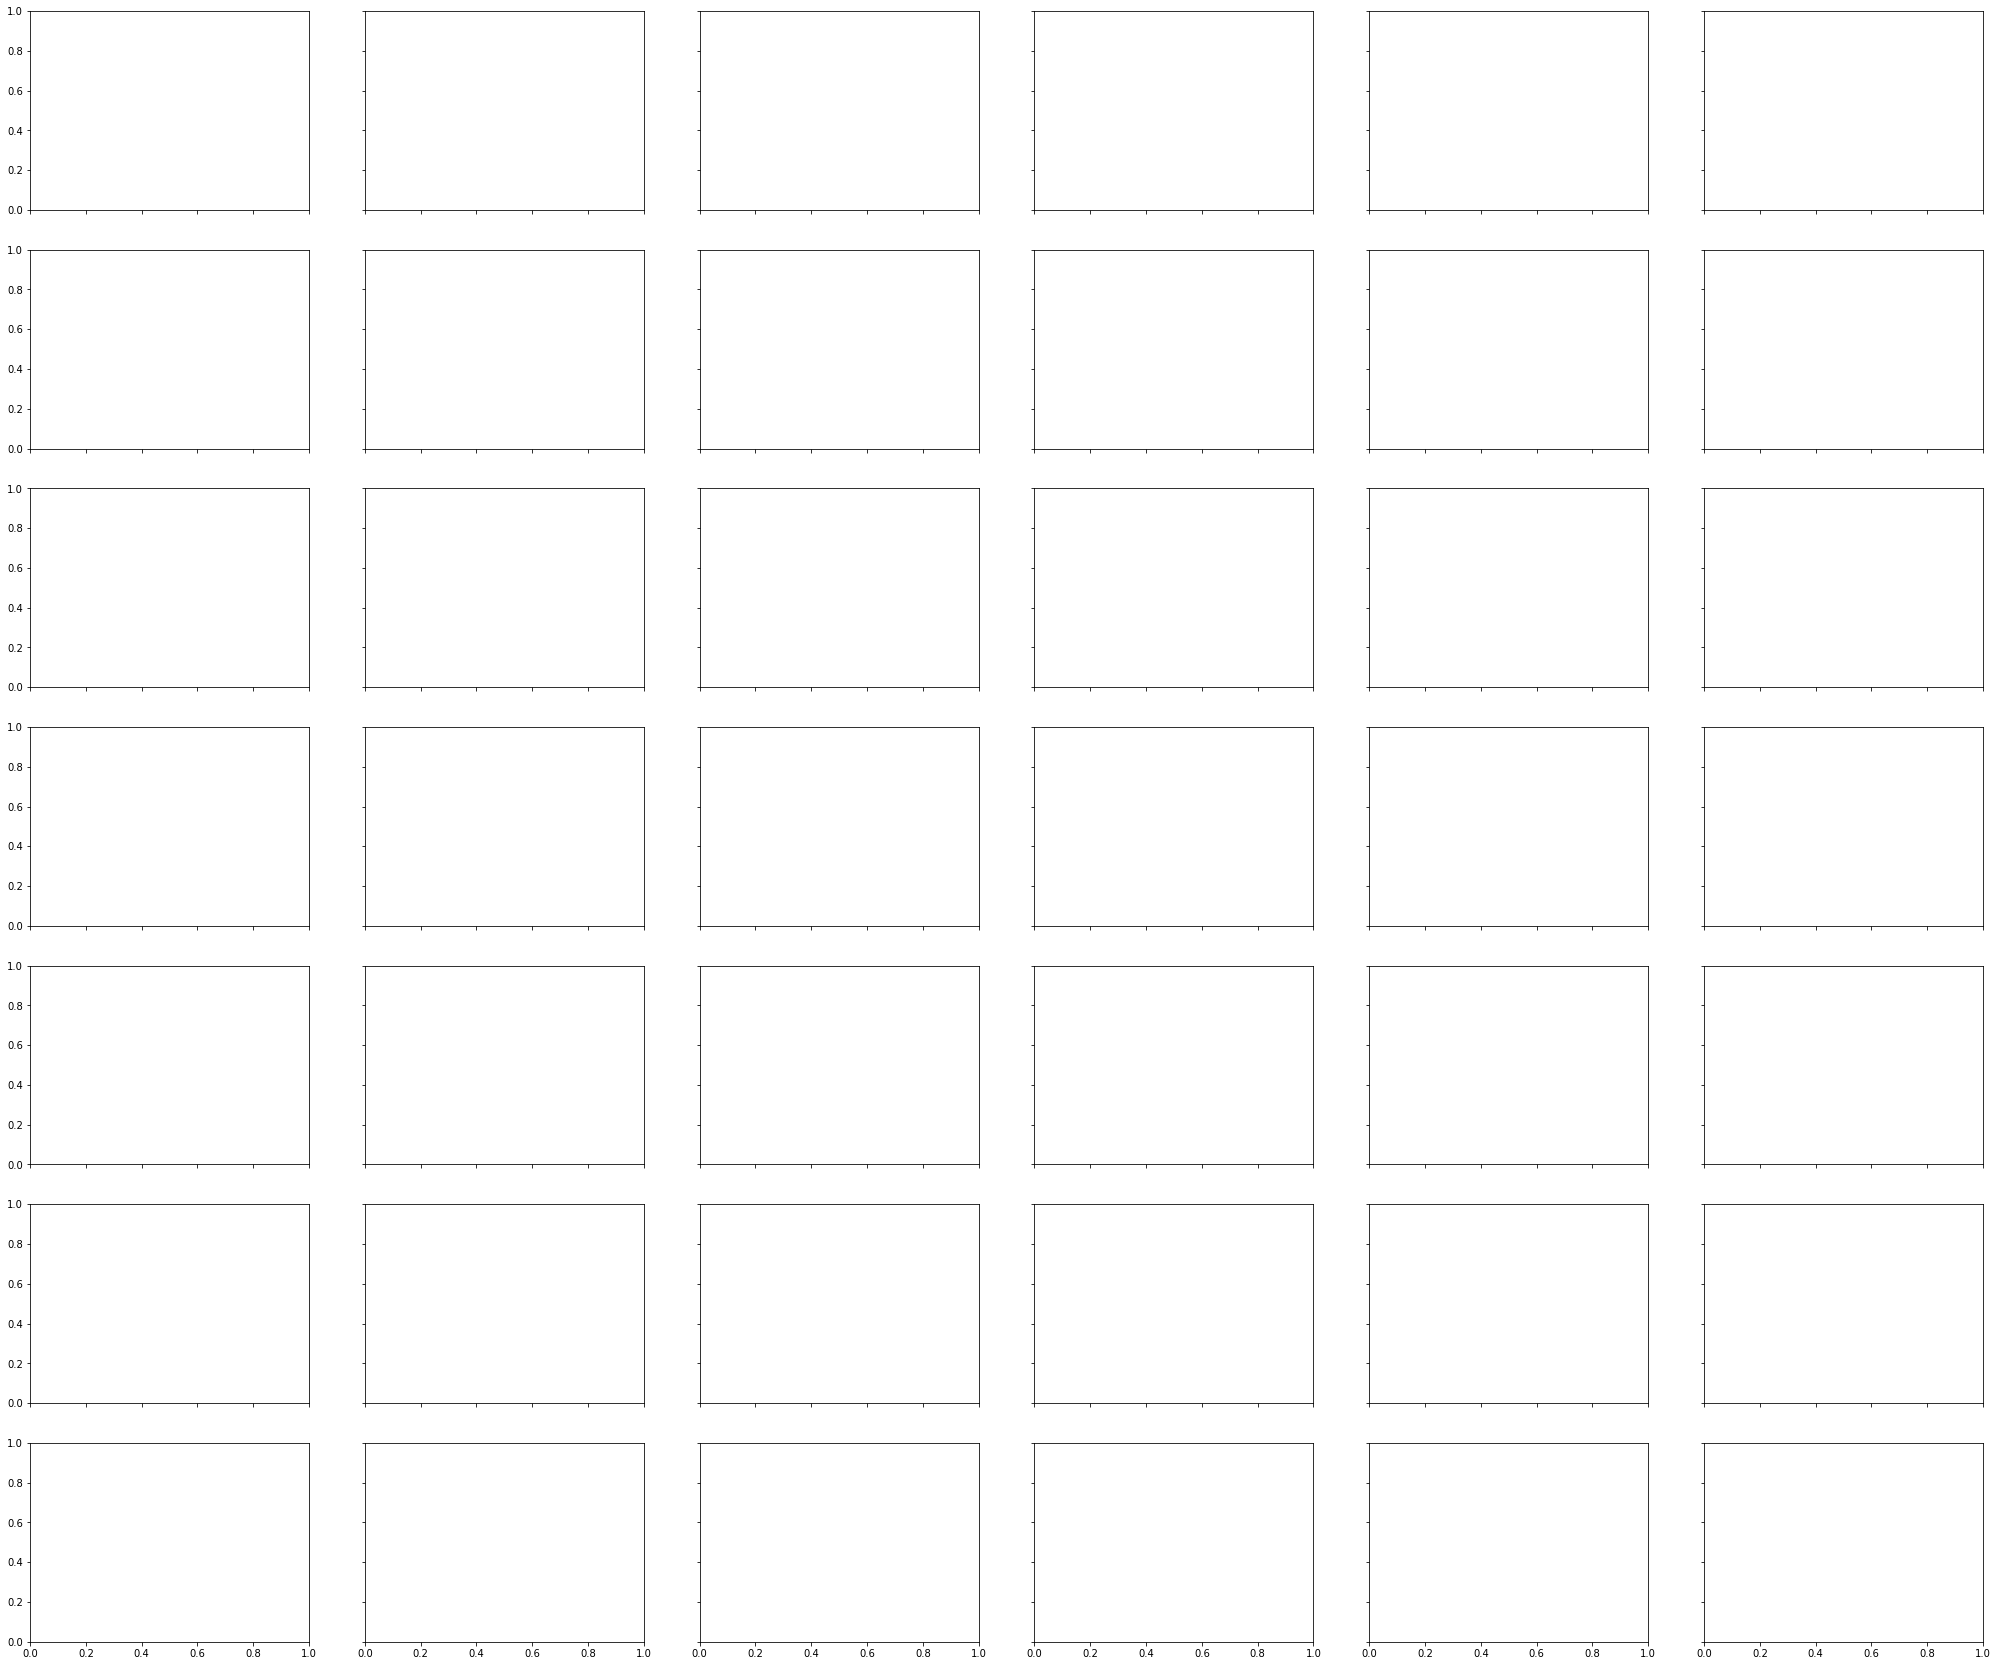

In [65]:
fig, ax = plt.subplots(len(Copula_names),
                       len(risk_measures), 
                       figsize=(5*len(Copula_names),5*len(risk_measures)),
                       sharey=True,  sharex=True)


for i, C in enumerate(Copula_names):
    for j, rm in enumerate(risk_measures):
        ax[i,j].step(x=h_4plot_arr[j].loc[C,:].index, y=h_4plot_arr[j].loc[C,:], label=risk_measures[j])
        if j==0:
            ax[i,j].set_ylabel(Copula_names[i])
        if i==0:
            ax[i,j].set_title(rename_rm(risk_measures[j]))
plt.tight_layout(pad=0.01)
plt.savefig('../latex/_pics/OHRs_CRIX_future_Open.pdf', transparent=True)

The overall strategy:
1. observe copula across risk reduction objective
- Kick out Frank because of HEs and PnL
- Other copula are producing similar results of HEs and PnL under the same risk reduction objective
-- PnL, conditional PnL (conditioned on extremes of RS)
- Gumbel Copula ex-ante hedge extreme by keeping a high h*
- None of the copula can escape from dependence break 

2. observe risk reduction objectives across copula
- 99% VaR and ES are too sensitive 
- ERM is a smoothed version ES --> give consistent results

1. h is high to begin with, Gumbel is consistently high, pick some of the extreme better then the others
2. consistently high h 

normal time, no extreme, h<<1
if there is extreme, correltation is higher, if one concerns extremes, maintain high h before extremes
connection to Gumbel
- combination of risk reduction objective and copula produce sensitive h*s. 
- Gumbel is better on extremes,because there is a high h ex-ante. high capture the 
- 
